# Extra Hint 2-a
## $2\times2$ lights out

To help you working with week 2-a(3 by 3 lights out), we made the circuit to solve the 2 by 2 lights out. Please check it out.
The board is given as: 
```
lights = [0, 0, 1, 1]
```

We will explain the policy of this answer. As we learned in Week-1, Grover's algorithm is able to extract a specific state(winning state) from $N$ superposition states using the "oracle" of the $\sqrt{N}$ times. While in last week's problem the "winning state" was already given as a binary vector, this week's problem is a bit more complex.  We take the winning state as a "pattern that all lights go out when flipped on a given board".

The "when flipped on a given board" part is implemented by the `flip_tile()` function (see below), and the `all_zero()` function is used to determine if the pattern is "lights out" or not.

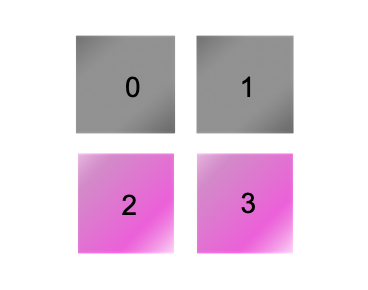

In [1]:
from IPython.display import Image, display
Image("hint_2a_board.png")

First, prepare the binary vector of the question.

In [2]:
lights = [0, 0, 1, 1]

Then you need to create a function that maps the binary vector(`lights`) in question to the quantum register(`tile`).

In [3]:
def map_board(lights, qc, qr):
    j = 0
    for i in lights:
        if i==1:
            qc.x(qr[j])
            j+=1
        else:
            j+=1

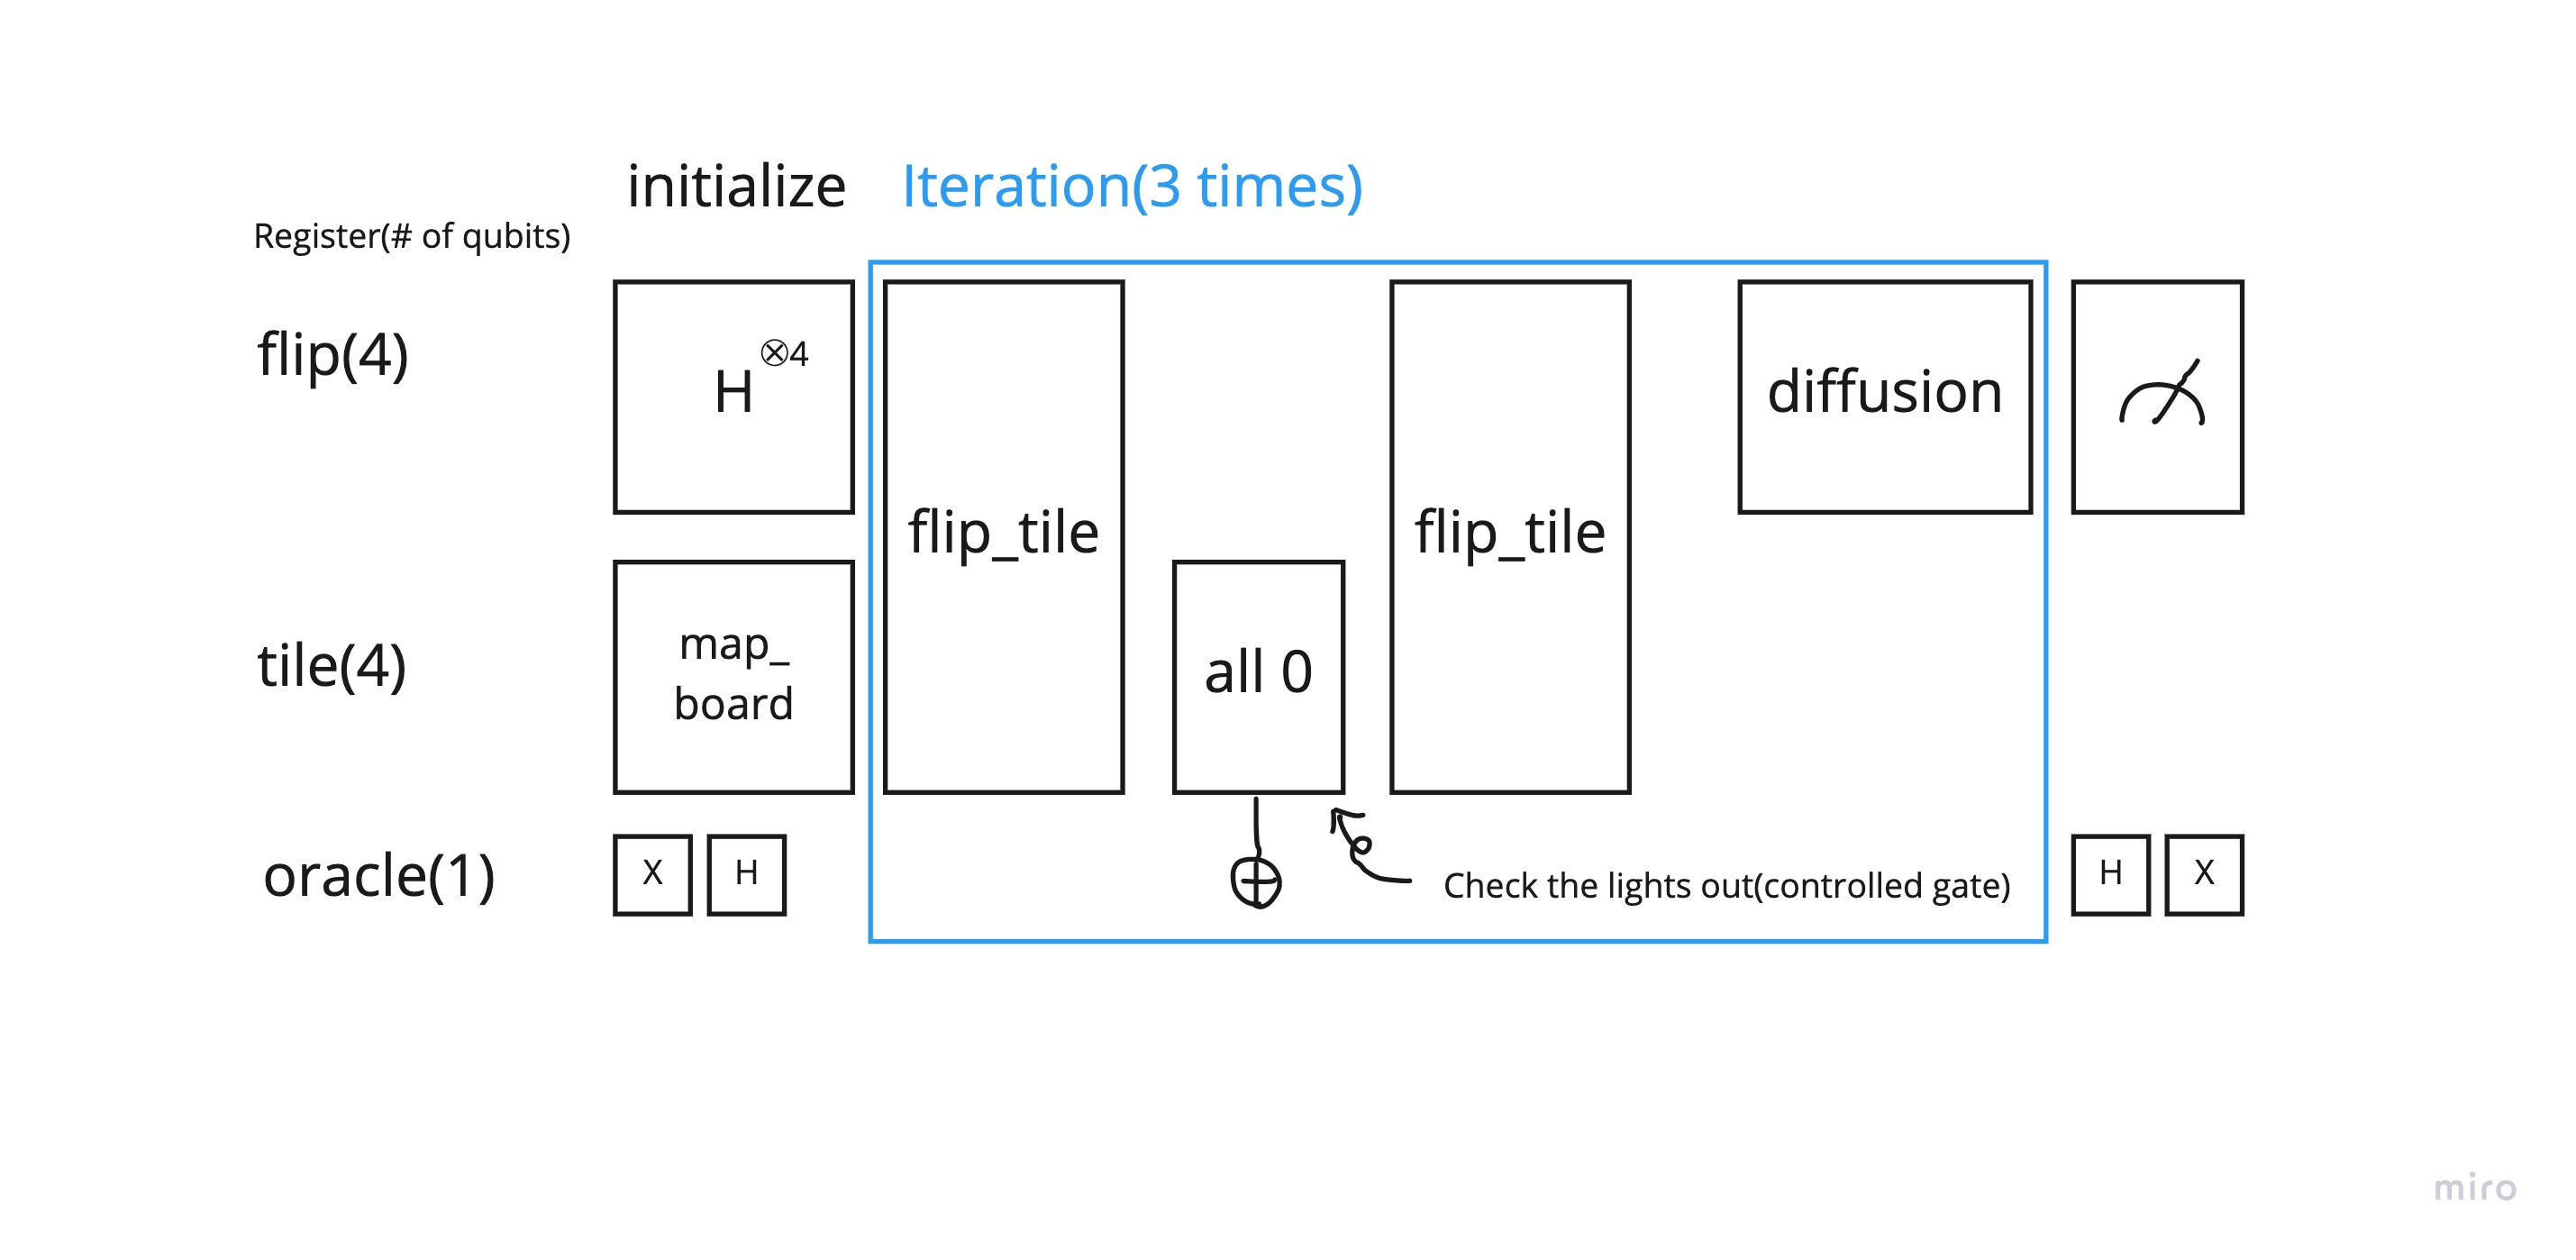

In [4]:
from IPython.display import Image, display
Image("hint_2a_circuit.jpg")

In [5]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
tile = QuantumRegister(4)
flip = QuantumRegister(4)
oracle = QuantumRegister(1)
result = ClassicalRegister(4)
#9 qubit + 4bit
qc = QuantumCircuit(oracle, tile, flip, result)

Before we run the oracle of Grover algorithm, we need to make some preparations. Let's call this function `initialize`().
1. map_board
2. Create superposition in the `flip` register. This represents candidates of solution.
3. Initializes the qubit that stores the oracle(which mark the solution that turns everything off) result in phase

In [6]:
def initialize():
    map_board(lights, qc, tile)

    qc.h(flip[:])
    
    qc.x(oracle[0])
    qc.h(oracle[0])

Here we implements the function which change the board state(in `tile`) based on the solution candidates(in `flip`)

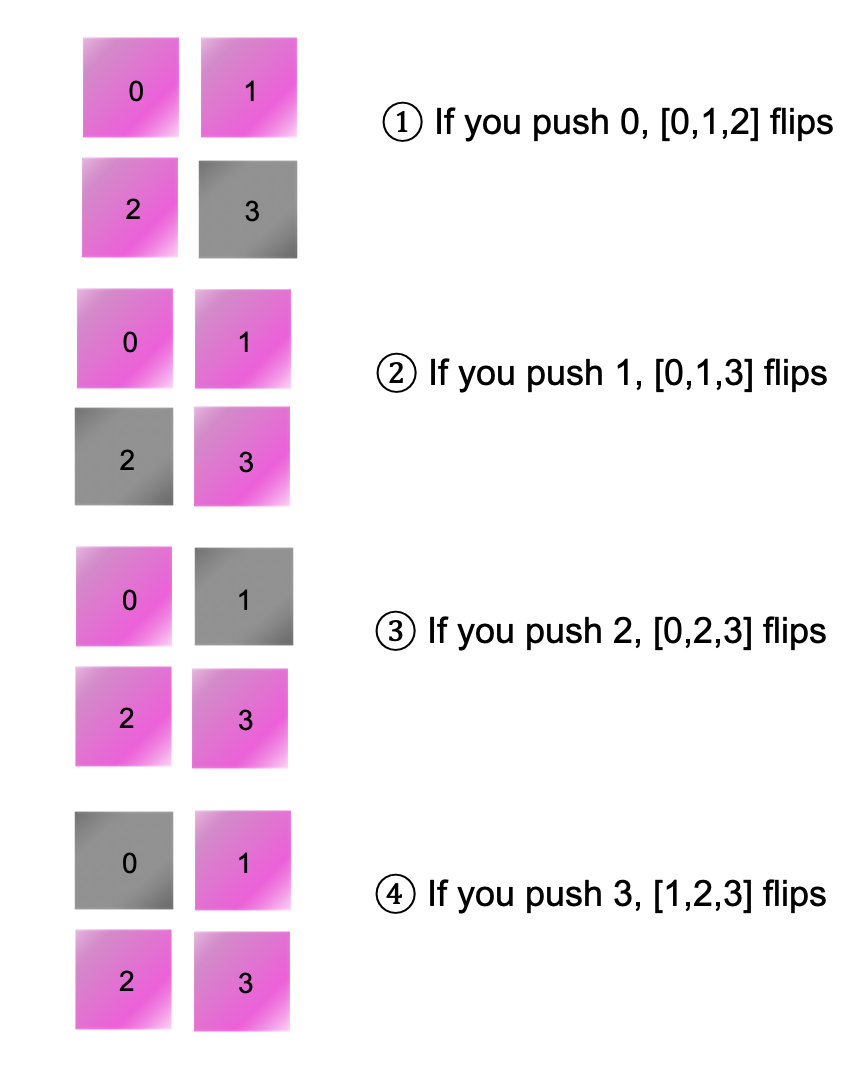

In [7]:
Image("hint_2a_flip_tile.png")

These four operations can be built from CX gates as shown.

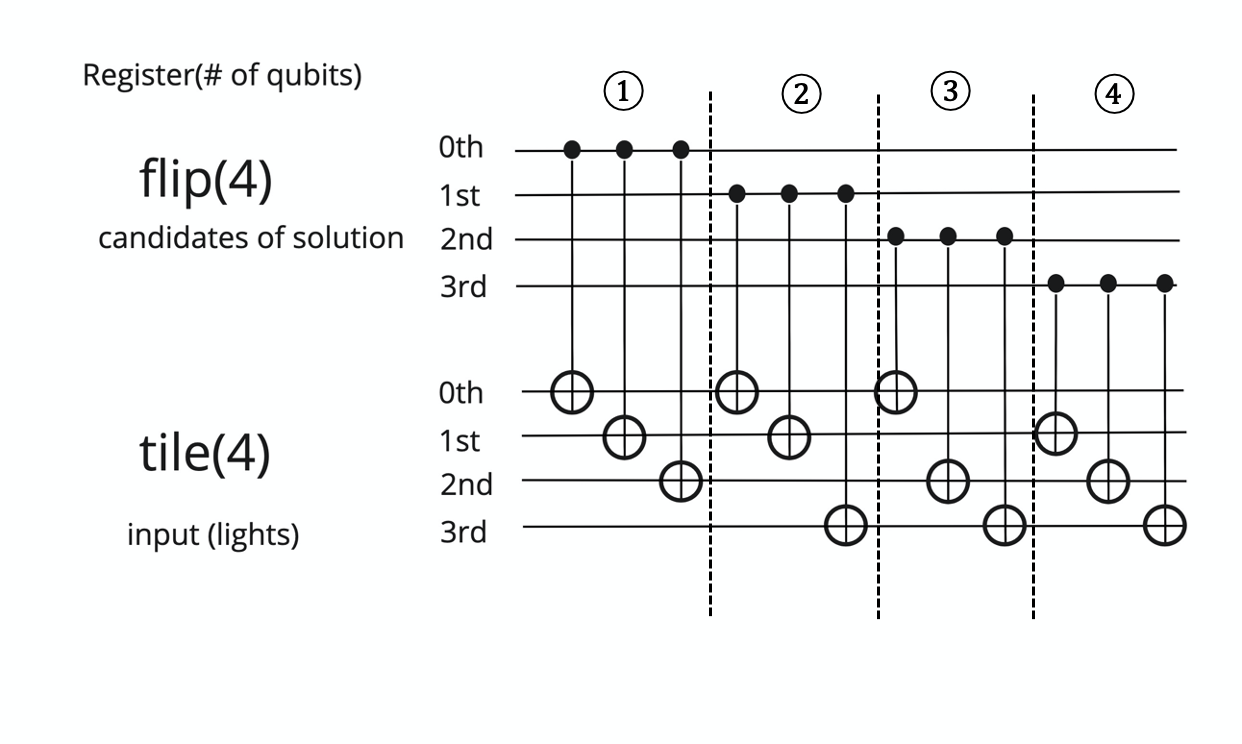

In [8]:
Image("hint_2a_flip_tile_circuit.png")

In [9]:
# Subroutine for oracle
# Calculate what the light state will be after pressing each solution candidate. 
def flip_tile(qc,flip,tile):
    qc.cx(flip[0], tile[0])
    qc.cx(flip[0], tile[1])
    qc.cx(flip[0], tile[2])
    qc.cx(flip[1], tile[0])
    qc.cx(flip[1], tile[1])
    qc.cx(flip[1], tile[3])
    qc.cx(flip[2], tile[0])
    qc.cx(flip[2], tile[2])
    qc.cx(flip[2], tile[3])
    qc.cx(flip[3], tile[1])
    qc.cx(flip[3], tile[2])
    qc.cx(flip[3], tile[3])

`all_zero()` function  is a function to check if all the lights are off, which can be built using the mct gate(cccx gate).

In [10]:
def all_zero(qc, tile):
    qc.x(tile[0:4])
    qc.mct(tile[0:4], oracle[0])
    qc.x(tile[0:4])

Let's write down the entire circuit. Since the solution space is $2^4$, the optimal number of iteration is about $\frac{\pi}{4} \sqrt{2^4} - \frac{1}{2} \risingdotseq 2.641$, so try it $3$ times. 

For more details about the number of iteration, please see the [Hint from Dr.Ryoko](https://github.com/qiskit-community/IBMQuantumChallenge2020/blob/main/hints/hint_1b.pdf) for week 1-B.

In [11]:
# create the circuit
initialize()
qc.barrier()
# the number of iteration is 3
for i in range(3):
    # oracle
    flip_tile(qc,flip,tile)
    
    qc.barrier()
    
    all_zero(qc, tile)
    
    qc.barrier()
    
    # U^dagger of flip_tile function is flip_tile itself.
    flip_tile(qc,flip,tile)
    
    # diffusion
    qc.h(flip)
    qc.x(flip)
    qc.h(flip[3])
    qc.mct(flip[0:3], flip[3])
    qc.h(flip[3])
    qc.x(flip)
    qc.h(flip)
    qc.barrier()

# Uncompute
qc.h(oracle[0])
qc.x(oracle[0])
qc.barrier()

# Measurement
qc.measure(flip,result)
qc.barrier()
# Make the Out put order the same as the input.
qc = qc.reverse_bits() 

You can also calculate the cost of the circuit.

In [12]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroll the circuit
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circuit = pm.run(qc)

# obtain gates
gates=new_circuit.count_ops()
print(gates)

OrderedDict([('u3', 298), ('cx', 264), ('barrier', 12), ('measure', 4)])


The cost of the circuit is 298 + 264*10 = 2938.

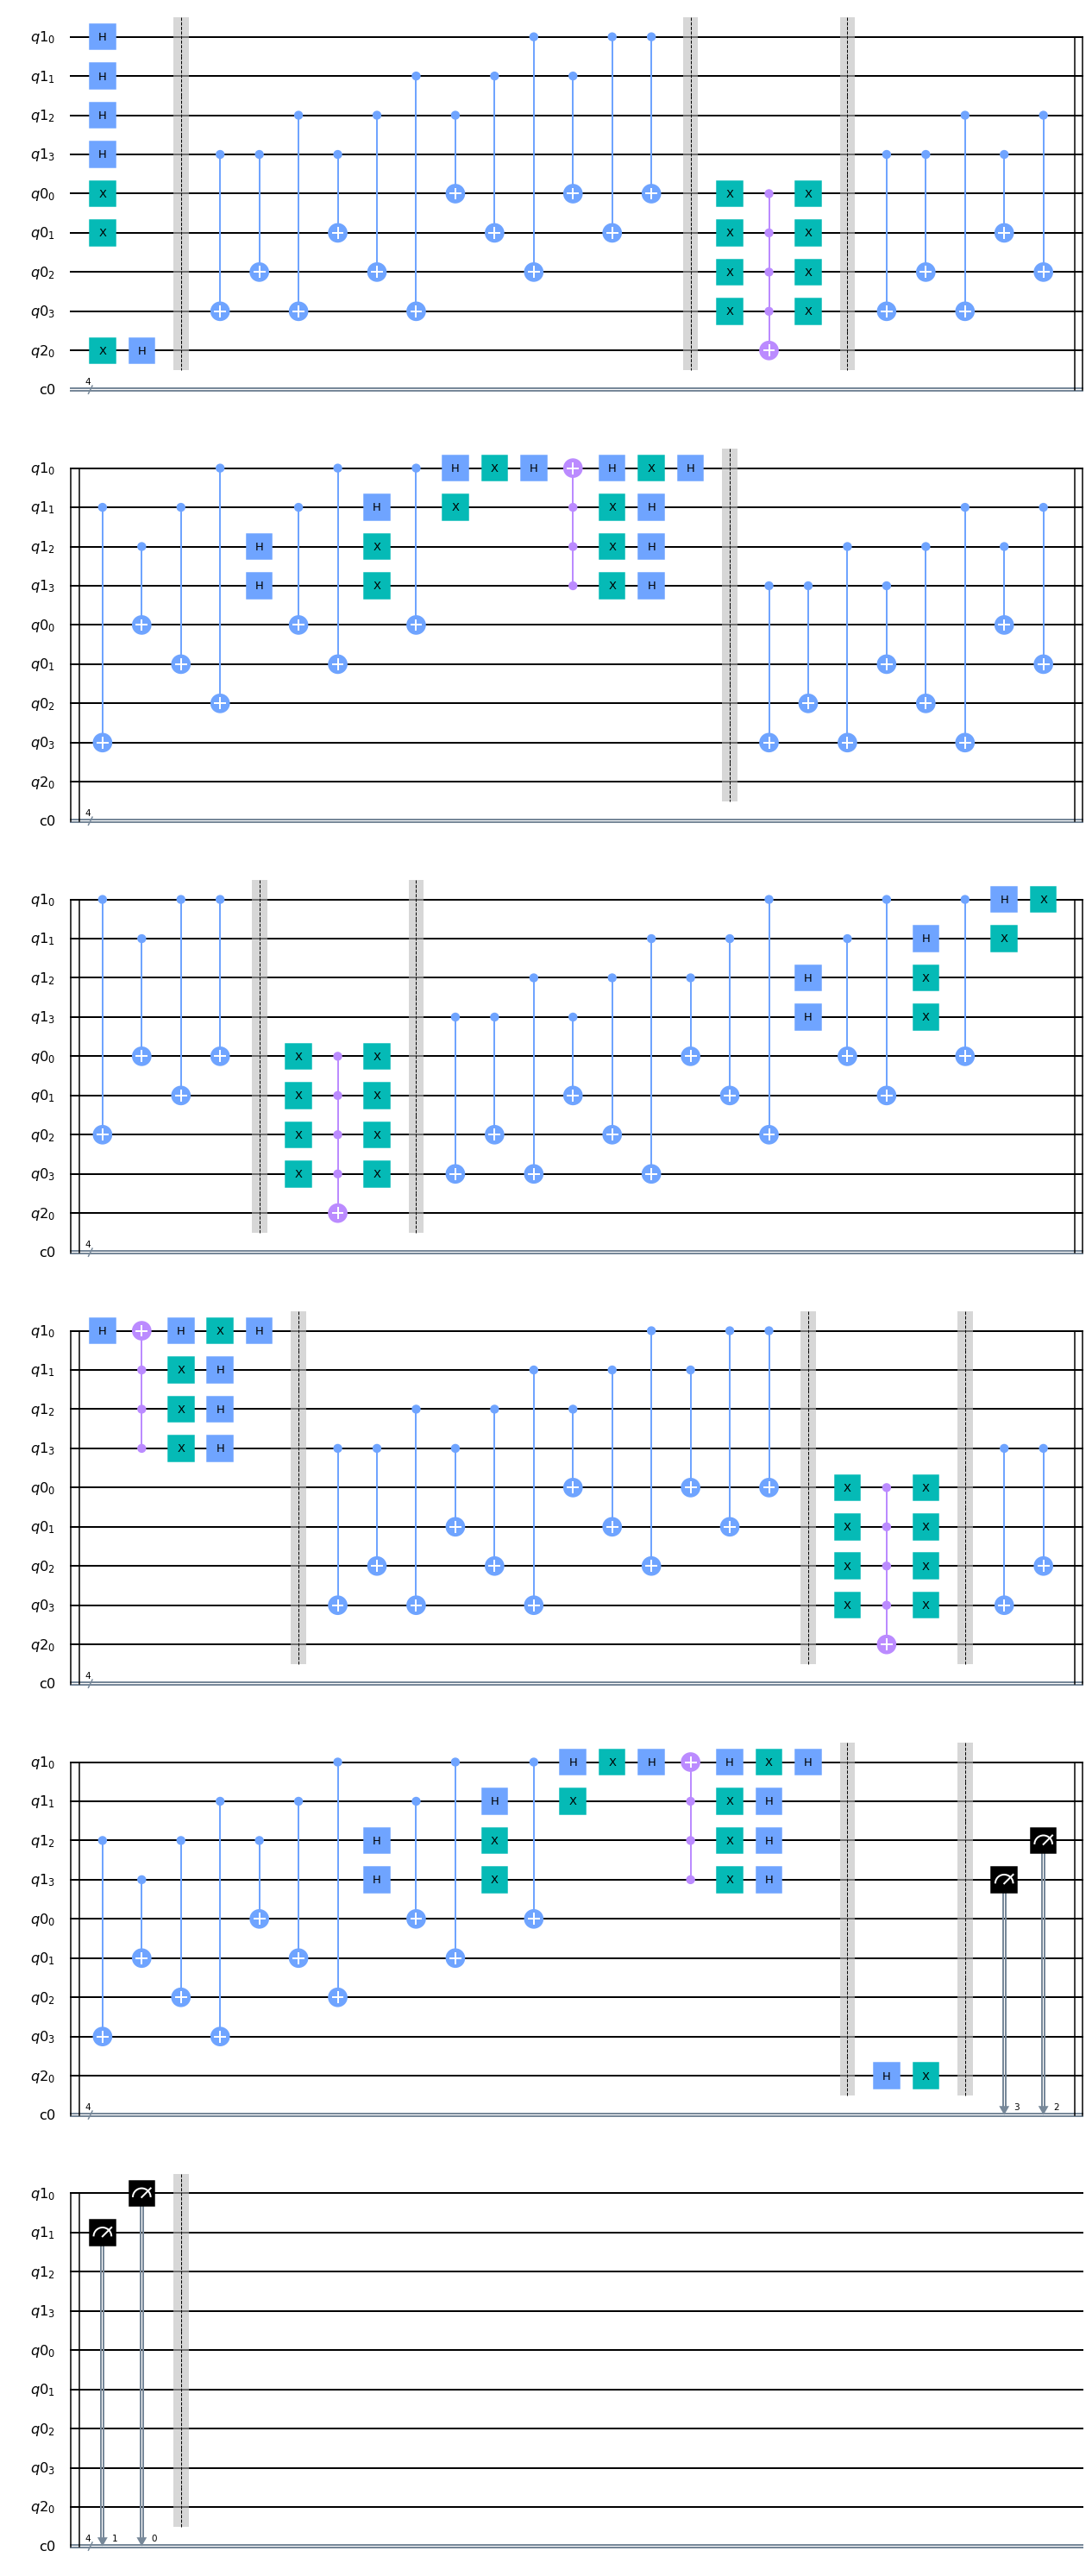

In [13]:
qc.draw(output='mpl')

Let's run the circuit and see if it works properly!

In [14]:
%%time
from qiskit import IBMQ, execute
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')
job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
result = job.result()
count = result.get_counts()

/Users/parton/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


CPU times: user 348 ms, sys: 24.8 ms, total: 373 ms
Wall time: 11.9 s


Sort by the number of observations.

In [15]:
score_sorted = sorted(count.items(), key=lambda x:x[1], reverse=True)
final_score = score_sorted[0:20]
final_score

[('1100', 7705),
 ('0100', 29),
 ('1000', 26),
 ('1110', 24),
 ('1001', 22),
 ('0011', 20),
 ('0101', 20),
 ('0000', 19),
 ('0010', 19),
 ('1011', 19),
 ('1111', 19),
 ('0111', 18),
 ('1101', 17),
 ('0001', 15),
 ('0110', 14),
 ('1010', 14)]

The answer is 1100! We think this exercise is quite complex for someone who is new to quantum programming, but we believe there is something to learn. Good luck!